In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Flow 4 Prerequisite - Data setup

- Imports essential data processing libraries
- Executes a BigQuery SQL query to fetch all records from data-cloud-demo5.next25_demo_ds.events table
- Loads the query results into a pandas DataFrame named df

In [40]:
import pandas as pd
import numpy as np
import pandas_gbq

sql = "SELECT * FROM `data-cloud-demo5.next25_demo_ds.events`"
project_id = "data-cloud-demo5"
df = pandas_gbq.read_gbq(sql, project_id, dialect="standard")

Downloading: 100%|██████████|


Preview the dataframe

In [41]:
df.head(2)

,event_id,user_id,device_id,event_type,timestamp,details,location,bytes_transferred,severity,source_ip,destination_ip
0,66559,40,849,malware_detected,2025-01-29 10:55:47.792358+00:00,Adware detected on device Desktop 105 in Maso...,Masonview,5467,High,9.63.195.37,149.109.162.136
1,846,342,817,malware_detected,2024-11-26 19:36:47.258751+00:00,Adware detected on device Desktop 177 in Elli...,Ellisonland,7577,High,82.195.66.116,None


Create contextual anomaly by `user_id`

Statistical Calculations
- group_mean = group_df['bytes_transferred'].mean() calculates the average bytes transferred for each user
- group_std = group_df['bytes_transferred'].std() calculates the standard deviation of bytes transferred

These statistics establish the "normal" baseline for each user's network traffic

Group Size Filtering
- if len(group_df) > 240: only processes groups with more than 240 events
- This ensures enough data points for meaningful anomaly injection
- Prints the user_id and number of events for groups meeting this threshold


In [42]:
# First, group data by a context feature
groups = df.groupby('user_id')

for group_name, group_df in groups:
    # Calculate normal range for this group
    group_mean = group_df['bytes_transferred'].mean()
    group_std = group_df['bytes_transferred'].std()

    # Select a small percentage of rows in this group
    if len(group_df) > 240:  # Only if group has enough data
        print(f"group_name: {group_name}, num of row: {len(group_df)}")

        anomaly_count = max(1, int(0.5 * len(group_df)))
        group_anomalies = np.random.choice(group_df.index, size=anomaly_count, replace=False)

        # Randomly create anomaly at 5-10 standard deviation from mean.
        df.loc[group_anomalies, 'bytes_transferred'] = int(group_mean + group_std * np.random.uniform(5, 10))

50 246


Update timestamp datatype to datetime64.

In [43]:
if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
    df['timestamp'] = pd.to_datetime(df['timestamp'])

df.dtypes

,0
event_id,Int64
user_id,Int64
device_id,Int64
event_type,object
timestamp,"datetime64[us, UTC]"
details,object
location,object
bytes_transferred,Int64
severity,object
source_ip,object


We can see that the anomaly user has user_id 50.

In [44]:
df.loc[group_anomalies]

,event_id,user_id,device_id,event_type,timestamp,details,location,bytes_transferred,severity,source_ip,destination_ip
16478,16841,50,293,malware_detected,2024-02-13 22:25:41.351859+00:00,Spyware detected on device Desktop Z 729 in Ea...,East Scott,167697568,High,201.214.218.201,137.224.234.33
81163,97643,50,622,logout,2024-11-22 12:58:05.653143+00:00,User bethgardner logged out from Adamtown usin...,Adamtown,167697568,Medium,214.94.37.192,88.218.216.252
22087,43941,50,418,login,2024-07-09 08:21:38.620545+00:00,User bethgardner logged in from North Kathrynv...,North Kathrynville,167697568,High,80.192.171.153,None
22084,36367,50,259,login,2024-08-28 10:28:25.768538+00:00,User bethgardner logged in from Heidifort usin...,Heidifort,167697568,High,168.171.223.126,158.76.43.25
52764,97628,50,790,logout,2024-11-20 14:28:52.668882+00:00,User bethgardner logged out from Brianchester ...,Brianchester,167697568,Low,65.201.71.107,215.60.29.166
...,...,...,...,...,...,...,...,...,...,...,...
11245,60735,50,69,network_connection,2024-09-06 13:31:47.791049+00:00,Outgoing connection to None:30903 from 156.115...,Bryanville,167697568,High,156.115.153.60,None
81133,10916,50,781,file_access,2024-03-29 22:51:49.897412+00:00,User bethgardner accessed file: determine..txt...,New Bradleyfurt,167697568,Medium,80.184.35.219,159.91.25.5
12040,99953,50,427,malware_detected,2024-07-28 04:58:56.124106+00:00,Ransomware detected on device Desktop 890 in ...,Port Thomasborough,167697568,High,223.144.254.4,None
98886,62027,50,977,software_update,2024-10-05 16:24:57.510067+00:00,Web Browser updated to version 1.5.5 on device...,Coreymouth,167697568,Medium,65.186.124.189,204.30.185.51


This visualization helps to identify patterns in network traffic over time.

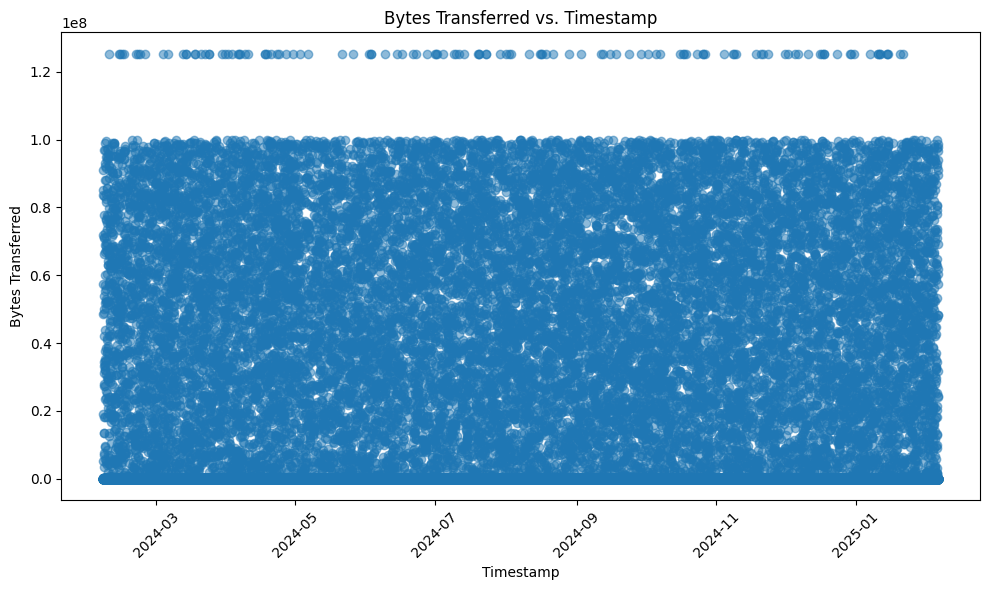

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['timestamp'], df['bytes_transferred'], alpha=0.5)
plt.xlabel('Timestamp')
plt.ylabel('Bytes Transferred')
plt.title('Bytes Transferred vs. Timestamp')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Save the modified dataset to `events_test` table.

In [6]:
pandas_gbq.to_gbq(df, 'data-cloud-demo5.next25_demo_ds.events_test', project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 6765.01it/s]


## FLow 4 Introduction

By using bigquery built in python notebook, you get the following benefits:
- Built in jupyter notebook, no need to jump to different IDE
- Gemini code assist to generate code
- Visualization recommendation


In [7]:
import pandas_gbq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

project_id = "data-cloud-demo5"


## Load Dataset from BQ

Pass in the prompt and get Gemini to create Python code to load the data.

In [8]:
# prompt: Load  table_id = "data-cloud-demo5.event_test"

import pandas_gbq

sql = "SELECT * FROM `data-cloud-demo5.next25_demo_ds.events_test`"
project_id = "data-cloud-demo5"
df = pandas_gbq.read_gbq(sql, project_id, dialect="standard")

Downloading: 100%|██████████|


Check that data has been successfully loaded.

In [9]:
df.head(3)

,event_id,user_id,device_id,event_type,timestamp,details,location,bytes_transferred,severity,source_ip,destination_ip
0,66559,40,849,malware_detected,2025-01-29 10:55:47.792358+00:00,Adware detected on device Desktop 105 in Maso...,Masonview,5467,High,9.63.195.37,149.109.162.136
1,846,342,817,malware_detected,2024-11-26 19:36:47.258751+00:00,Adware detected on device Desktop 177 in Elli...,Ellisonland,7577,High,82.195.66.116,None
2,52327,408,783,malware_detected,2024-11-13 00:44:17.169335+00:00,Adware detected on device Desktop 181 in Cunn...,Cunninghamland,98019,High,208.168.155.64,192.23.0.57


## Data transformation

Now let's do further data transformation by create new features for year, month and day and hour.

In [27]:
# prompt: extract all columns, in addition, create new column for year, month, date, hours from data-cloud-demo5.event_test

import pandas_gbq

sql = """
SELECT *,
EXTRACT(YEAR FROM timestamp) AS year,
EXTRACT(MONTH FROM timestamp) AS month,
EXTRACT(DAY FROM timestamp) AS day,
EXTRACT(HOUR FROM timestamp) as hour
FROM `data-cloud-demo5.next25_demo_ds.events_test`
"""
df = pandas_gbq.read_gbq(sql, project_id="data-cloud-demo5", dialect="standard")

Downloading: 100%|██████████|


Let's preview the data, and then click `View plot recommendation`.

In [11]:
df.head(3)

,event_id,user_id,device_id,event_type,timestamp,details,location,bytes_transferred,severity,source_ip,destination_ip,year,month,day,hour
0,66559,40,849,malware_detected,2025-01-29 10:55:47.792358+00:00,Adware detected on device Desktop 105 in Maso...,Masonview,5467,High,9.63.195.37,149.109.162.136,2025,1,29,10
1,846,342,817,malware_detected,2024-11-26 19:36:47.258751+00:00,Adware detected on device Desktop 177 in Elli...,Ellisonland,7577,High,82.195.66.116,None,2024,11,26,19
2,52327,408,783,malware_detected,2024-11-13 00:44:17.169335+00:00,Adware detected on device Desktop 181 in Cunn...,Cunninghamland,98019,High,208.168.155.64,192.23.0.57,2024,11,13,0


## Visualization


Let's do a visualization plot using 2D Histogram Heatmap to identify anomaly.

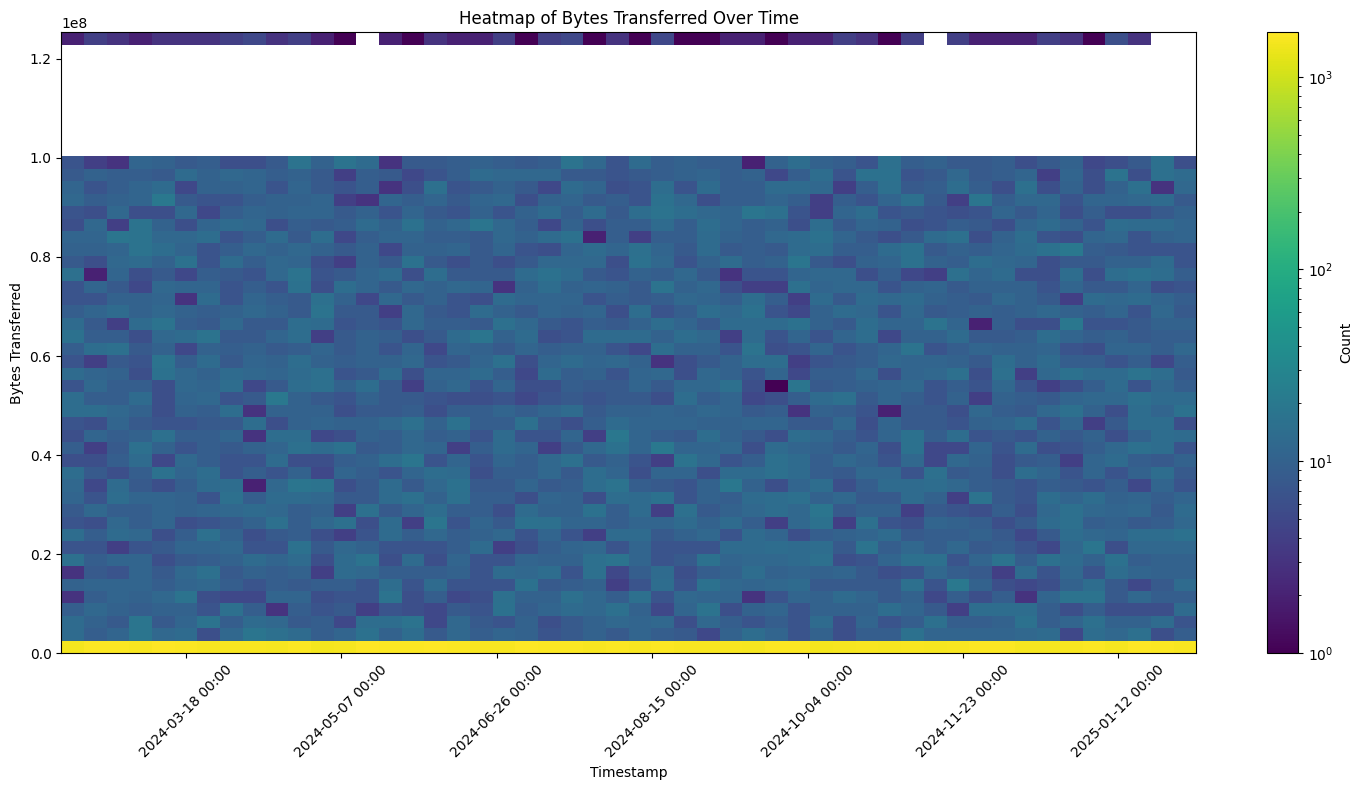

In [38]:
import numpy as np
from matplotlib import colors
import matplotlib.dates as mdates

# Create a heatmap of bytes transferred over time
plt.figure(figsize=(15, 8))

# Convert timestamps to numeric values for plotting
timestamps_numeric = mdates.date2num(df['timestamp'])

# Create 2D histogram using hist2d
plt.hist2d(timestamps_numeric,
           df['bytes_transferred'],
           bins=50,
           norm=colors.LogNorm())  # Using log normalization for better visualization

plt.colorbar(label='Count')
plt.xlabel('Timestamp')
plt.ylabel('Bytes Transferred')
plt.title('Heatmap of Bytes Transferred Over Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Format x-axis to show readable dates
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.tight_layout()
plt.show()

Identify the user_id whose `bytes_transferred` exceed 1.2e8. It should show `user_id` 50.

In [47]:
df_user = df[df['bytes_transferred'] >= 1.2e8]
df_user.head(2)

,event_id,user_id,device_id,event_type,timestamp,details,location,bytes_transferred,severity,source_ip,destination_ip
19,34352,50,443,malware_detected,2024-09-08 04:24:09.201395+00:00,Adware detected on device Desktop 504 in West...,West Maryside,167697568,High,35.187.6.46,132.220.104.25
527,6231,50,829,malware_detected,2024-06-18 06:33:41.161269+00:00,Adware detected on device Firewall X 480 in Va...,Vasquezberg,167697568,High,211.114.28.54,55.201.27.77
